In [26]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [3]:
df = df.copy()
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'] 
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

In [4]:
pd.set_option('display.float_format', '{:.4f}'.format)
df.duration.describe(percentiles=[0.01, 0.25, 0.75, 0.95, 0.99])

count   3066766.0000
mean         15.6690
std          42.5944
min         -29.2000
1%            0.7833
25%           7.1167
50%          11.5167
75%          18.3000
95%          36.4667
99%          57.2500
max       10029.1833
Name: duration, dtype: float64

In [5]:
((df.duration >= 0.7) & (df.duration <= 58)).mean()

np.float64(0.9810448531123666)

In [6]:
df_filtered = df.copy()
df_filtered = df_filtered[(df_filtered.duration >= 0.7) & (df_filtered.duration <= 58)]
df_filtered.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0000,0.9700,1.0000,N,161,141,2,9.3000,1.0000,0.5000,0.0000,0.0000,1.0000,14.3000,2.5000,0.0000,8.4333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0000,1.1000,1.0000,N,43,237,1,7.9000,1.0000,0.5000,4.0000,0.0000,1.0000,16.9000,2.5000,0.0000,6.3167
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0000,2.5100,1.0000,N,48,238,1,14.9000,1.0000,0.5000,15.0000,0.0000,1.0000,34.9000,2.5000,0.0000,12.7500
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0000,1.9000,1.0000,N,138,7,1,12.1000,7.2500,0.5000,0.0000,0.0000,1.0000,20.8500,0.0000,1.2500,9.6167
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0000,1.4300,1.0000,N,107,79,1,11.4000,1.0000,0.5000,3.2800,0.0000,1.0000,19.6800,2.5000,0.0000,10.8333


In [7]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [8]:
df_filtered[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [9]:
df_filtered[categorical] = df_filtered[categorical].astype(str)

In [10]:
train_dicts = df_filtered[categorical + numerical].to_dict(orient='records')

In [11]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [12]:
target = 'duration'
y_train = df_filtered[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(X_train)

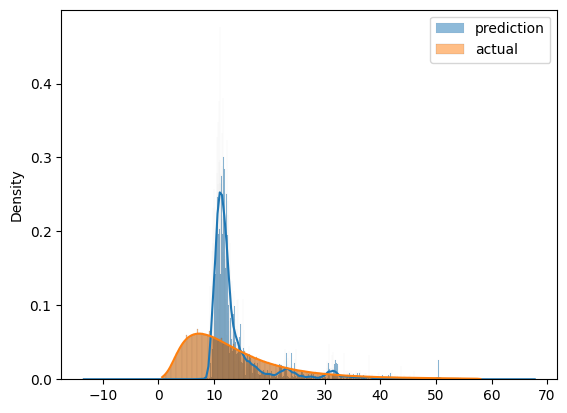

In [15]:
sns.histplot(y_pred, kde=True, label='prediction', stat='density')
sns.histplot(y_train, kde=True, label='actual', stat='density')

plt.legend()
plt.show()

In [16]:
mean_squared_error(y_train, y_pred)

57.86709264269403

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'] 

    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 0.7) & (df.duration <= 58)]

    categorical = ['PULocationID', 'DOLocationID']
    # numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)

    return df

In [18]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [19]:
len(df_train), len(df_val)

(3008635, 2855000)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] # 'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

26.837412856139554

In [30]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
# lasso = Lasso()
# lasso.fit(X_train, y_train)

# y_pred = lasso.predict(X_val)
# mean_squared_error(y_val, y_pred)

In [25]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)
mean_squared_error(y_val, y_pred)

26.49331372281507